# Анализ объявлений по продаже автомобилей с auto.drom.ru 

Участники группы: Щеглов Алексей, Байгужин Искандер, Зверев Алексей

__1. Соберем данные, спарсив их с auto.drom.ru, возьмем 2000 объявлений, которые находятся на первых 100 страницах сайта__


In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def get_page(p):
    url = 'https://auto.drom.ru/all/page{}/?minpower=50'.format(p)
    response = requests.get(url)
    tree = BeautifulSoup(response.content, 'html.parser')
    books = tree.find_all('a', {"class": "css-4zflqt e1huvdhj1"})

    infa = []

    for book in books:
        pric = book.find('span', {"class": "css-46itwz e162wx9x0"}).text[0:-2]
        price = int(pric.replace('\xa0', ''))
        try:
            info = book.find('div', {"class": "css-16kqa8y e3f4v4l2"}).text
        except:
            info = book.find('div', {"class": "css-d4igzo e3f4v4l2"}).text
        year = int(info.split(',')[1])
        model = info.split(',')[-2]
        dvig = list(book.find('span', {'class' : "css-1l9tp44 e162wx9x0"}))[0]
        volume = float(dvig[:3])
        if volume < 10:
            volume = volume
        else:
            volume = 0
        hors = dvig[-9:-5]
        horse = int(hors.strip('('))
        tip = book.find_all('span', {'class' : "css-1l9tp44 e162wx9x0"})[1].text
        typpe = tip.strip(',')
        try:
            corob = book.find_all('span', {'class' : "css-1l9tp44 e162wx9x0"})[2].text
            box = corob.strip(',')
            if box == 'АКПП' or box == 'вариатор' or box == 'механика' or box == 'автомат' or box == 'робот Коробка':
                box = box
            else:
                box = None            
        except:
            box = None           
        prob = book.find_all('span', {'class' : "css-1l9tp44 e162wx9x0"})[-1].text.strip(' км')
        try:
            probeg = int(prob.replace(' ', ''))
        except:
            probeg = 0 #делаем ноль, потому что чаще всего это новые машины, и лишь иногда у машин просто не указан пробег
        try:
            priv = book.find_all('span', {'class' : "css-1l9tp44 e162wx9x0"})[3].text
            privod = priv.strip(',')
            if privod == 'задний' or privod == 'передний' or privod == '4WD':
                privod = privod
            else:
                privod = None
        except:
            privod = None
        infa.append({'Цена': price, 'Год': year, 'Модель' : model, 'Двигатель (л)' : volume, 'ЛС': horse, 'Коробка': box, 'Тип': typpe, 'Привод': privod, 'Пробег, км': probeg})

    return infa

infa = []

for p in range(1, 101):
    infa.extend(get_page(p))

df = pd.DataFrame(infa)
print(df.shape)
df

(2000, 9)


,Цена,Год,Модель,Двигатель (л),ЛС,Коробка,Тип,Привод,"Пробег, км"
0,5590000,2020,BMW 5-Series,2.0,184,АКПП,бензин,задний,31400
1,4250000,2022,Toyota bZ4X,0.0,214,АКПП,электро,4WD,212
2,5200000,2023,BYD Tang,1.5,137,вариатор,бензин,передний,200
3,1590000,2015,Nissan Teana,2.5,173,вариатор,бензин,передний,124000
4,3850000,2023,Geely Monjaro,2.0,238,АКПП,бензин,4WD,10
...,...,...,...,...,...,...,...,...,...
1995,570000,2008,Toyota Passo,1.0,71,АКПП,бензин,передний,119000
1996,685000,2010,Chevrolet Epica,2.0,143,АКПП,бензин,передний,150373
1997,920000,2008,Hyundai Tucson,2.0,141,механика,бензин,4WD,255000
1998,7500000,2021,Toyota Land Cruiser Prado,2.8,200,АКПП,дизель,4WD,25000


__Описание переменных:__

* `Цена` - указанная стоимость автомобиля в объявлении в рублях
* `Год` - год автомобиля 
* `Модель` - модель автомобиля 
* `Двигатель (л)`  - объем двигателя в литрах
* `ЛС`  - количество лошадиных сил
* `Коробка` - тип коробки передач
* `Тип` - тип двигателя (топливо)
* `Привод` - привод автомобиля
* `Пробег, км` - указанный пробег автомобиля в км


Не во всех объявлениях указывают полностью все компоненты, взятые нами для анализа, поэтому мы написали код, который заменяет отсутствующую компоненту на пустоту(чаще всего не указывают коробку и привод), это можно увидеть ниже

In [5]:
df.isna().sum()

Цена               0
Год                0
Модель             0
Двигатель (л)      0
ЛС                 0
Коробка          110
Тип                0
Привод             3
Пробег, км         0
dtype: int64

Избавляемся от непонятных данных (NaN), удаляя их. И обновляем индексы, а после также удаляем новый появившийся столбик с индексами, так как он не нужен

In [6]:
df.dropna(inplace=True)
df.reset_index(inplace=True)

In [7]:
df.drop('index', axis=1, inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1890 entries, 0 to 1889
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Цена           1890 non-null   int64  
 1   Год            1890 non-null   int64  
 2   Модель         1890 non-null   object 
 3   Двигатель (л)  1890 non-null   float64
 4   ЛС             1890 non-null   int64  
 5   Коробка        1890 non-null   object 
 6   Тип            1890 non-null   object 
 7   Привод         1890 non-null   object 
 8   Пробег, км     1890 non-null   int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 133.0+ KB


Так как в объявлениях встречаются электрокары, у которых не указан литраж двигателя, заменим 'электро' на пустоту

In [9]:
df.loc[df['Тип'] == 'электро', 'Двигатель (л)'] = None

In [10]:
df

,Цена,Год,Модель,Двигатель (л),ЛС,Коробка,Тип,Привод,"Пробег, км"
0,5590000,2020,BMW 5-Series,2.0,184,АКПП,бензин,задний,31400
1,4250000,2022,Toyota bZ4X,NaN,214,АКПП,электро,4WD,212
2,5200000,2023,BYD Tang,1.5,137,вариатор,бензин,передний,200
3,1590000,2015,Nissan Teana,2.5,173,вариатор,бензин,передний,124000
4,3850000,2023,Geely Monjaro,2.0,238,АКПП,бензин,4WD,10
...,...,...,...,...,...,...,...,...,...
1885,570000,2008,Toyota Passo,1.0,71,АКПП,бензин,передний,119000
1886,685000,2010,Chevrolet Epica,2.0,143,АКПП,бензин,передний,150373
1887,920000,2008,Hyundai Tucson,2.0,141,механика,бензин,4WD,255000
1888,7500000,2021,Toyota Land Cruiser Prado,2.8,200,АКПП,дизель,4WD,25000


__2. Визуализация данных__

Построим гистограммы для всех признаков, кроме "моделей", так как их слишком много

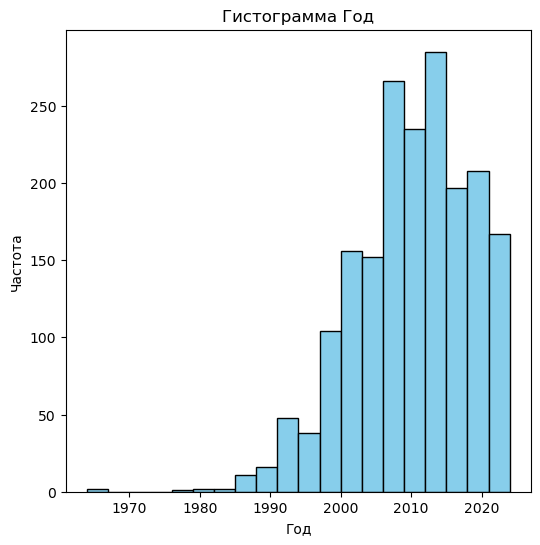

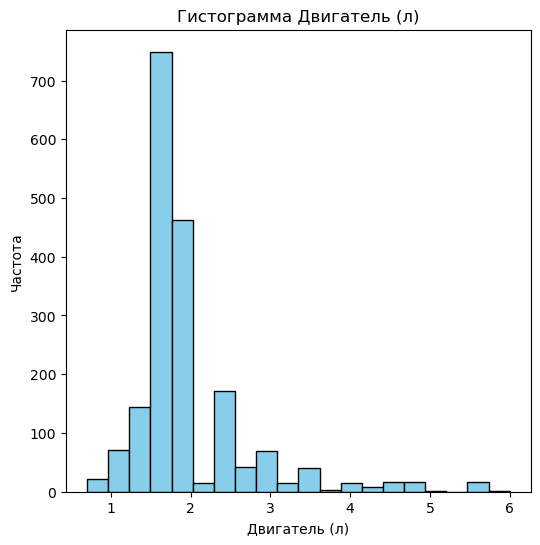

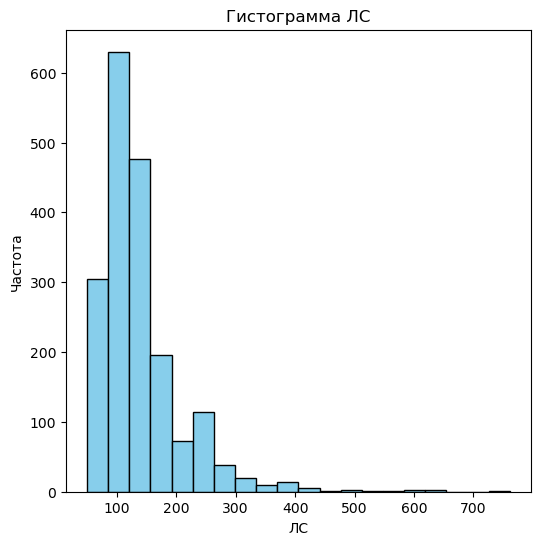

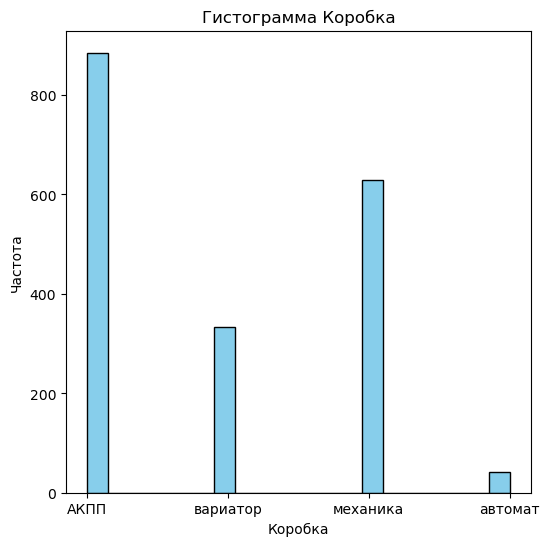

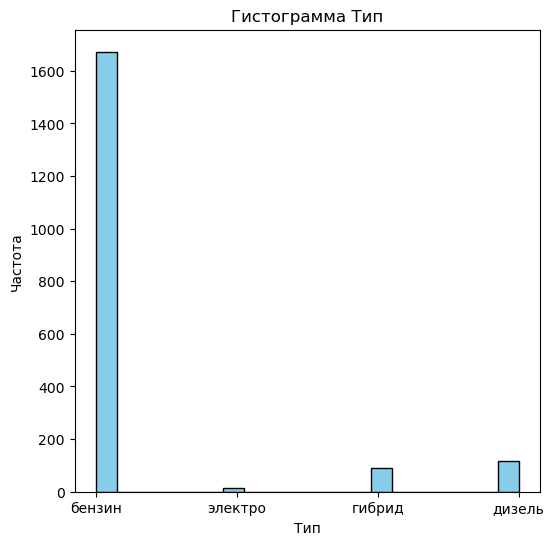

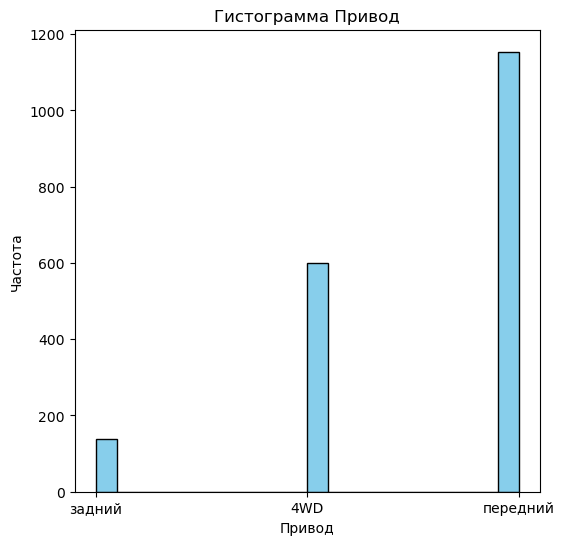

In [48]:
for column in df.columns:
    if column != 'Модель' and column != 'Пробег, км' and column != 'Цена': 
        plt.figure(figsize=(6, 6))
        plt.hist(df[column], bins=20, color='skyblue', edgecolor='black')
        plt.xlabel(column)
        plt.ylabel('Частота')
        plt.title(f'Гистограмма {column}')

Промежуточный вывод: больше всего в объявлениях встречаются поддержанные автомобили 2010-ых годов, объемом двигателя от 1,5 до 2 л, имеющие около 100 лс, коробкой АККП и чуть меньше с механикой на бензине с передним приводом.

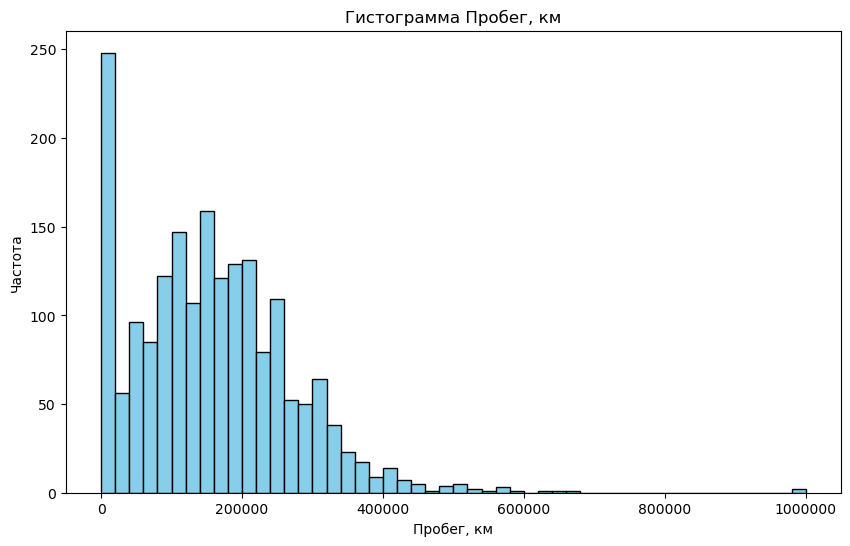

In [46]:
plt.figure(figsize=(10, 6))
plt.hist(df['Пробег, км'], bins=50, color='skyblue', edgecolor='black', log=False)
plt.ticklabel_format(style='plain', axis='x')# Добавляем log=False
plt.xlabel('Пробег, км')
plt.ylabel('Частота')
plt.title(f'Гистограмма Пробег, км')
plt.show() 


По гистограмме пробега, можно заметить, что это в среднем в объявлениях встречаются машины с пробегом до 300.000 км, однако также очень ярко выражены совсем новые автомобили без пробега 

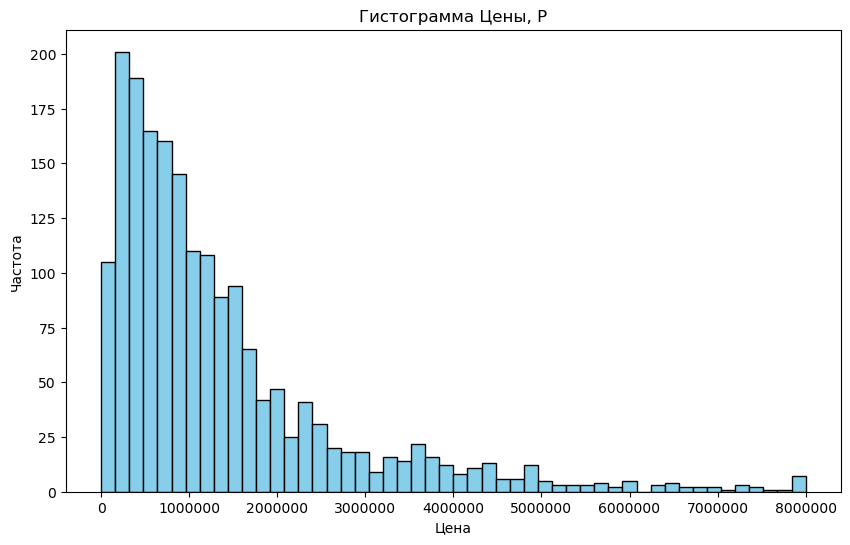

In [49]:
plt.figure(figsize=(10, 6))
plt.hist(df['Цена'], bins=50, color='skyblue', edgecolor='black', log=False, range=(0, 8000000))
plt.ticklabel_format(style='plain', axis='x')
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.title(f'Гистограмма Цены, Р')
plt.show() 

По гистограмме цены автомобилей можно заметить, что она имеет распределение схожее с Пуассоновским. 
В выборке наиболее часто встречаются автомобили до 1.000.000 рублей


__Посмотрим, как распределены цены автомобилей в зависимости от каждого из признаков__

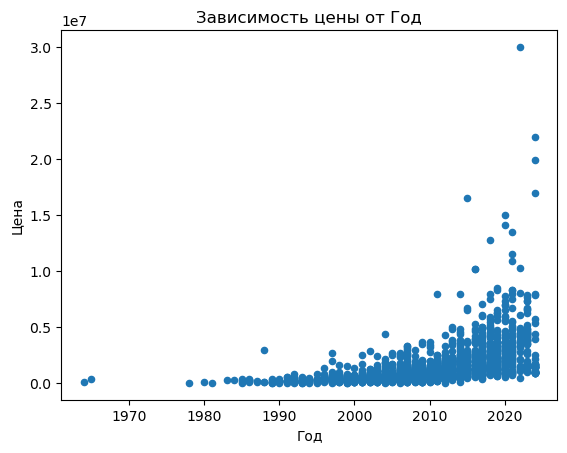

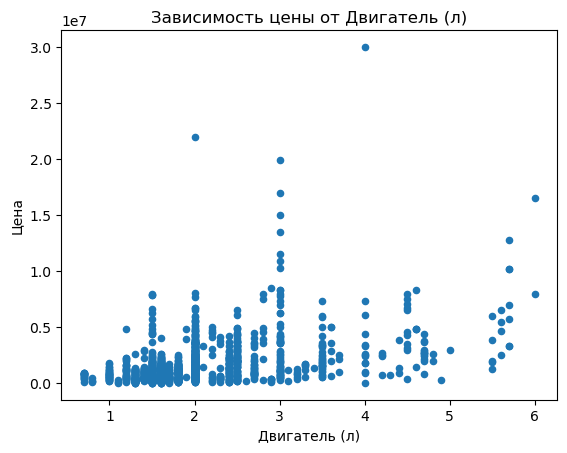

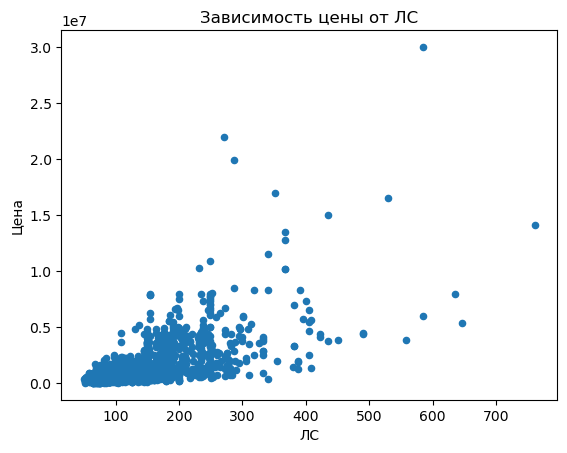

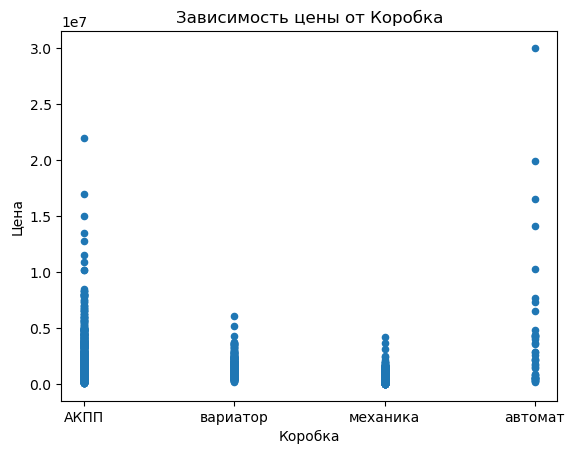

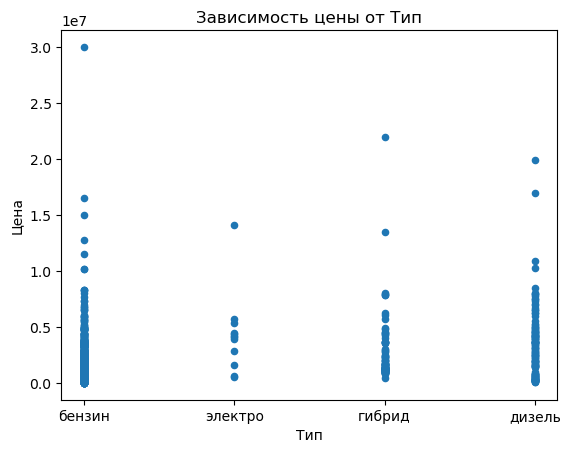

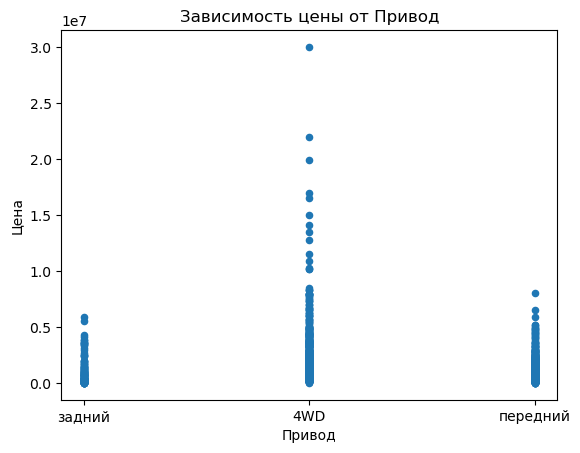

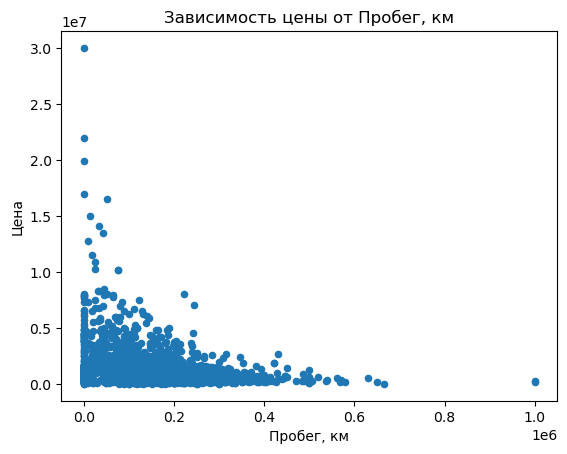

In [12]:
for column in df.columns:
    if column != 'Цена' and column != 'Модель' :  
        df.plot(x=column, y='Цена', kind='scatter')
        plt.xlabel(column)
        plt.ylabel('Цена')
        plt.title(f'Зависимость цены от {column}')
        plt.show()

Построим ящик с усами, который покажет выбросы цены в зависимости от типа двигателя

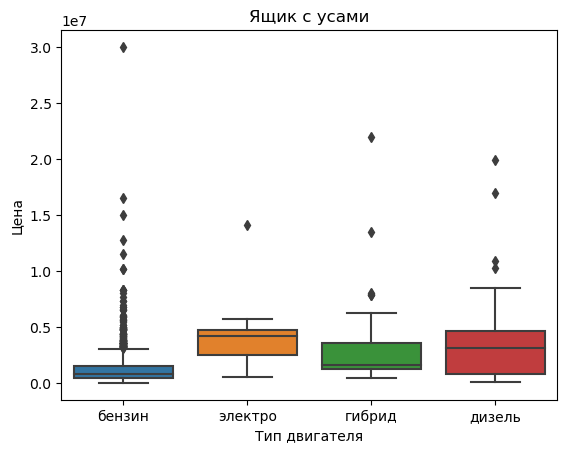

In [52]:
sns.boxplot(x='Тип', y='Цена', data=df)

plt.xlabel('Тип двигателя')
plt.ylabel('Цена')
plt.title('Ящик с усами');

Отчетливо видно, что машины с бензиновым двигателем имеют больше выбросов, чем какие либо другие, что логично, ведь именно с этим типом двигателя наибольшее количество объявлений

Далее построим корреляционную матрицу данных

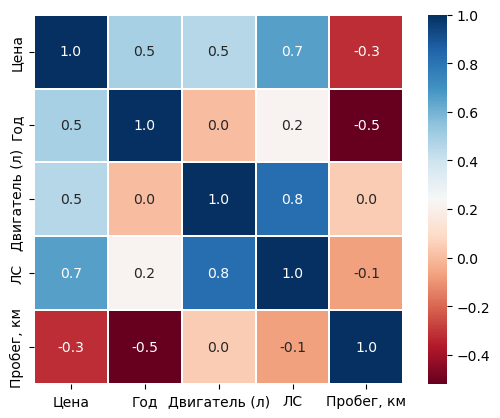

In [14]:
num_columns = df.select_dtypes(include=['int64', 'float64']).columns

sns.heatmap(df[num_columns].corr(method='pearson'), 
            square=True, annot=True, fmt=".1f", 
            linewidths=0.1, cmap="RdBu");

Из матрицы видны логичные вещи, к примеру, то, что пробег и цена, пробег и год имеют отрицательные зависимости. Скорее всего, именно эти критерии имеют приоритет при выборе автомобиля. 